In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Binomial Option Pricing

In [2]:
def binomial_tree_option(s0, k, r, t, sigma, n, option_type = 'call', american = False):
    dt = t / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_price = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        for j in range(i + 1):
            stock_price[j, i] = s0 * (u ** (i - j)) * (d ** j)

    option_price = np.zeros((n + 1, n + 1))
    if option_type == 'call':
        option_price[:, n] = np.maximum(stock_price[:, n] - k, 0)
    elif option_type == 'put':
        option_price[:, n] = np.maximum(k - stock_price[:, n], 0)

    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            option_price[j, i] = np.exp(-r * dt) * (p * option_price[j, i + 1] + (1 - p) * option_price[j + 1, i + 1])
            if american:
                if option_type == 'call':
                    option_price[j, i] = max(option_price[j, i], stock_price[j, i] - k)
                elif option_type == 'put':
                    option_price[j, i] = max(option_price[j, i], k - stock_price[j, i])

    return stock_price, option_price

In [6]:
s0, k, r, t, sigma, n = 100, 100, 0.1, 1, 0.4, 5

stock_tree, option_tree = binomial_tree_option(s0, k, r, t, sigma, n, option_type = 'call', american = False)

print("Stock Price Tree:")
print(stock_tree)

print("\nOption Price Tree:")
print(option_tree)

Stock Price Tree:
[[100.         119.58837337 143.01379046 171.02786571 204.52944262
  244.59343349]
 [  0.          83.62016907 100.         119.58837337 143.01379046
  171.02786571]
 [  0.           0.          69.92332675  83.62016907 100.
  119.58837337]
 [  0.           0.           0.          58.47000405  69.92332675
   83.62016907]
 [  0.           0.           0.           0.          48.89271624
   58.47000405]
 [  0.           0.           0.           0.           0.
   40.88417198]]

Option Price Tree:
[[ 20.99359213  33.06413875  50.63488386  74.94892179 106.50957528
  144.59343349]
 [  0.           9.21987013  16.02905126  27.26396831  44.99392313
   71.02786571]
 [  0.           0.           2.46965007   4.92519094   9.8222441
   19.58837337]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]


## Montecarlo Simulate

### Cash-or-Nothing Put Option

In [62]:
def cash_or_nothing_put_mc(cash, s, k, r, t, v, n, m):
    dt = t / n
    drift = (r - 0.5 * v ** 2) * dt
    discount_factor = np.exp(-r * t)
    
    premium_results = []
    stock_prices = np.linspace(10, 200, 500)

    for s0 in stock_prices:
        sum_payoff = 0
        for _ in range(m):
            st = s0
            for _ in range(n):
                z = np.random.randn()
                st *= np.exp(drift + v * np.sqrt(dt) * z)
            sum_payoff += cash if st <= k else 0
        premium_results.append(discount_factor * (sum_payoff / m))

    return stock_prices, premium_results

In [63]:
def plot_cash_or_nothing_put_mc(stock_prices, premium_results_1, premium_results_2):

    plt.figure(figsize = (10, 6))
    plt.plot(stock_prices, premium_results_1, label = "T = 1")
    plt.plot(stock_prices, premium_results_2, label = "T = 2")

    plt.xlabel("Stock Price (S)")
    plt.ylabel("Premium")
    plt.title("Cash-or-Nothing Put Option Premium (Monte Carlo)")
    plt.legend()
    plt.grid(True)
    plt.show()

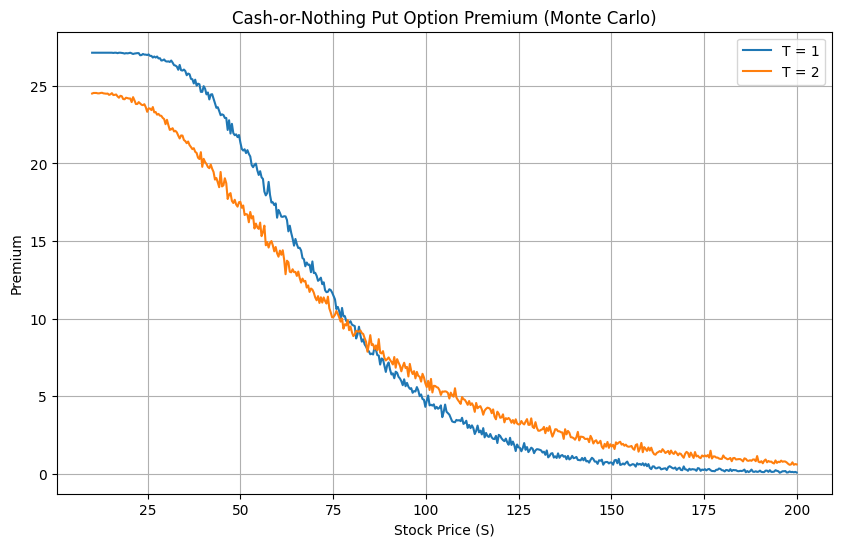

In [64]:
cash, s, k, r, t, v, n, m = 30, 70, 70, 0.1, 1, 0.4, 30, 2000

stock_prices, premium_results_1 = cash_or_nothing_put_mc(cash, s, k, r, t, v, n, m)
t = 2
stock_prices, premium_results_2 = cash_or_nothing_put_mc(cash, s, k, r, t, v, n, m)

plot_cash_or_nothing_put_mc(stock_prices, premium_results_1, premium_results_2)

### Tian Model

In [39]:
import numpy as np

def TianBinomial(OutputFlag, AmeEurFlag, CallPutFlag, S, K, T, r, c, v, N):
    n_list = np.arange(0, (N + 1), 1)

    if CallPutFlag == 'C':
        z = 1
    elif CallPutFlag == 'P':
        z = -1
    else:
        return 'Call or put not defined'

    dt = T / N

    H = np.exp((v ** 2) * dt)
    u = 0.5 * np.exp(c * dt) * H * (H + 1 + np.sqrt(H ** 2 + 2 * H - 3))
    d = 0.5 * np.exp(c * dt) * H * (H + 1 - np.sqrt(H ** 2 + 2 * H - 3))
    p = (np.exp(c * dt) - d) / (u - d)

    df = np.exp(-r * dt)

    max_pay_off_list = []
    for i in n_list:
        i = i.astype('int')
        max_pay_off = np.maximum(0, z * (S * u ** i * d ** (N - i) - K))
        max_pay_off_list.append(max_pay_off)

    for j in np.arange(N - 1, 0 - 1, -1):
        for i in np.arange(0, j + 1, 1):
            i = i.astype(int)
            if AmeEurFlag == 'e':
                max_pay_off_list[i] = (p * max_pay_off_list[i + 1] + (1 - p) * max_pay_off_list[i]) * df
            elif AmeEurFlag == 'a':
                max_pay_off_list[i] = np.maximum((z * (S * u ** i * d ** (j - i) - K)),
                                                 (p * max_pay_off_list[i + 1] + (1 - p) * max_pay_off_list[i]) * df)
        if j == 2:
            gamma = ((max_pay_off_list[2] - max_pay_off_list[1]) / (S * u ** 2 - S * u * d) - (
                    max_pay_off_list[1] - max_pay_off_list[0]) / (S * u * d - S * d ** 2)) / (
                            0.5 * (S * u ** 2 - S * d ** 2))
        if j == 1:
            delta = ((max_pay_off_list[1] - max_pay_off_list[0])) / (S * u - S * d)
    price = max_pay_off_list[0]

    variable_list = [delta, gamma, price]

    if OutputFlag == 'P':
        return price
    elif OutputFlag == 'd':
        return delta
    elif OutputFlag == 'g':
        return gamma
    elif OutputFlag == 'a':
        return variable_list
    elif OutputFlag == 'step factors':
        return u, d
    else:
        return 'Indicate if you want to return P, d, g or a'


In [40]:
def plot_tian_binomial_tree(S, T, N, u, d):
    dt = T / N
    stock_tree = np.zeros((N + 1, N + 1))

    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S * (u ** (i - j)) * (d ** j)

    plt.figure(figsize=(12, 8))
    for i in range(N + 1):
        for j in range(i + 1):
            plt.scatter(i, stock_tree[j, i], color='blue', s=20)
            if i < N:
                plt.plot([i, i + 1], [stock_tree[j, i], stock_tree[j, i + 1]], 'k-', lw=0.5)
                plt.plot([i, i + 1], [stock_tree[j, i], stock_tree[j + 1, i + 1]], 'k-', lw=0.5)

    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")
    plt.title("Tian Model Binomial Tree")
    plt.grid(True)
    plt.show()

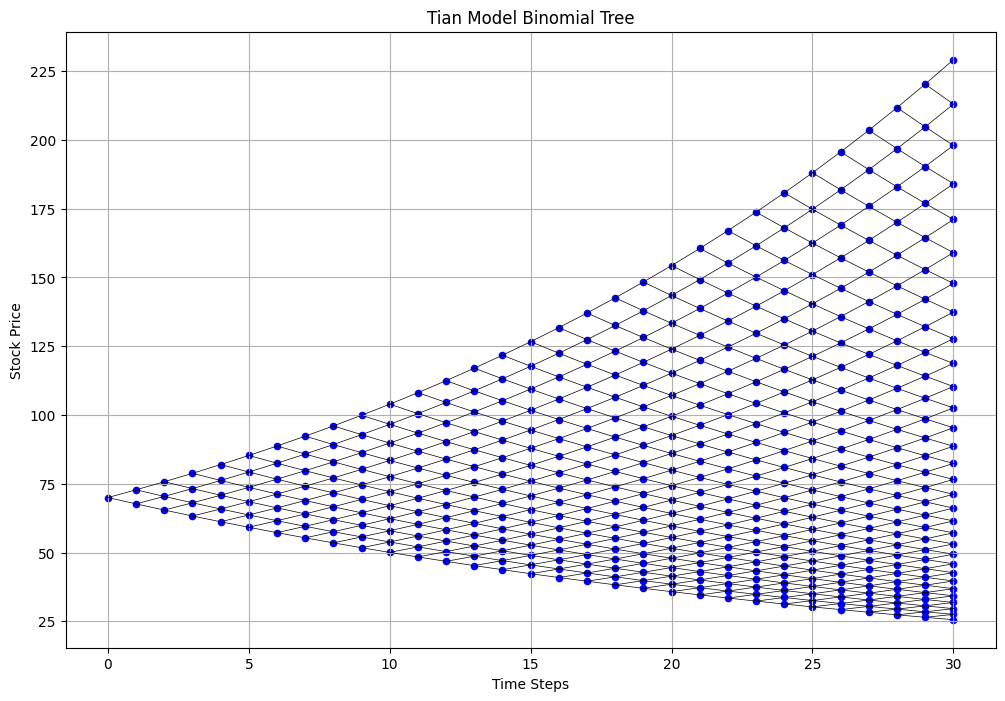

In [41]:
S = 70
K = 70
T = 1
N = 30
r = 0.05
v = 0.2
c = r

u, d = TianBinomial('step factors', 'e', 'C', S, K, T, r, c, v, N)
plot_tian_binomial_tree(S, T, N, u, d)